## インポート

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

np.random.seed(1234)

## データの読み込み

In [2]:
df = pd.read_csv('chap08/input/data-salary-3.txt')
df.head()

,X,Y,KID,GID
0,7,457,1,1
1,10,482,1,1
2,16,518,1,1
3,25,535,1,1
4,5,427,1,1


## メカニズム１：a, b の平均は業界によって異なるが、a, b のバラツキは業界を問わず一定とする

$ a_{avg}[g] $ ~ $ Normal(a_{avg\_all}, \sigma_{ag}) $

$ b_{avg}[g] $ ~ $ Normal(b_{avg\_all}, \sigma_{bg}) $

$a[k]$ ~ $ Normal(a_{avg}[GID[g]], \sigma_a)$

$b[k]$ ~ $ Normal(b_{avg}[GID[g]], \sigma_b)$

$Y[n]$ ~ $ Normal( a[KID[n]] + b[KID[n]] X[n], \sigma_y )$

$g = 1, ..., G$

$k = 1, ..., K$

$n = 1, ..., N$

In [3]:
model_code="""
data {
  int G;
  int K;
  int N;
  real<lower=0> X[N];
  real<lower=0> Y[N];
  int<lower=1,upper=G> K2G[K];
  int<lower=1,upper=K> KID[N];
}
parameters {
  real aavg_all;
  real bavg_all;
  real aavg[G];
  real bavg[G];
  real a[K];
  real b[K];
  real<lower=0> s_ag;
  real<lower=0> s_bg;
  real<lower=0> s_a;
  real<lower=0> s_b;
  real<lower=0> s_y;
}
model {
  for (g in 1:G) {
    aavg[g] ~ normal(aavg_all, s_ag);
    bavg[g] ~ normal(bavg_all, s_bg);
  }
  for (k in 1:K) {
    a[k] ~ normal(aavg[K2G[k]], s_a);
    b[k] ~ normal(bavg[K2G[k]], s_b);  
  }

  for (n in 1:N)
    Y[n] ~ normal(a[KID[n]]+b[KID[n]]*X[n], s_y);
}
"""

from pystan import StanModel

K2G = df[~df[['KID', 'GID']].duplicated()].GID
data = dict(N=df.shape[0], G=df.GID.nunique(), K=df.KID.nunique(), X=df.X, K2G=K2G, KID=df.KID, Y=df.Y)
sm = StanModel(model_code=model_code)

fit = sm.sampling(data=data, n_jobs=1, seed=1234)
fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b8866c67f9f8304959b334edb363f1c3 NOW.


Inference for Stan model: anon_model_b8866c67f9f8304959b334edb363f1c3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
aavg_all 311.87   50.09 812.27 -788.2 289.52 384.53 473.78 1164.3    263   1.01
bavg_all  20.59    4.37  83.74  -54.2  10.85  18.41  25.38 121.64    368    1.0
aavg[0]  360.37     0.8  29.11 303.37  340.7 360.68 379.85 417.68   1334    1.0
aavg[1]  298.73    0.48  14.13 270.15 289.67 298.86  307.8 326.66    880    1.0
aavg[2]  498.78    1.05  28.75 441.66 479.56 498.98  518.1 554.61    747    1.0
bavg[0]   13.09    0.06   2.74   7.68  11.25  13.02  14.93  18.59   2297    1.0
bavg[1]    28.6    0.03   1.41  25.72  27.68  28.59   29.5  31.43   1814    1.0
bavg[2]   12.53    0.07   2.47   7.67   10.9  12.59  14.14  17.39   1115    1.0
a[0]     365.72    0.69   26.7 315.01  347.4 366.42 384.08 418.56   1507    1.0
a[1]     35

## 業界平均 $a_{avg}[g]$ と $b_{avg}[g]$ の事後分布を作図する

C:\Users\eX\Anaconda3\lib\site-packages\seaborn\categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Users\eX\Anaconda3\lib\site-packages\seaborn\categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


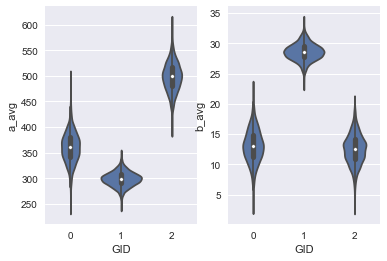

In [29]:
ms = fit.extract()

fig = plt.figure()
ax=plt.subplot(121)
plt.xlabel('GID')
plt.ylabel('a_avg')
sns.violinplot(data=ms['aavg'], color=sns.palettes.color_palette()[0])


ax=plt.subplot(122)
sns.violinplot(data=ms['bavg'], color=sns.palettes.color_palette()[0])
plt.xlabel('GID')
plt.ylabel('b_avg')

plt.show()